In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools
from itertools import combinations, chain
import time
import copy
import scipy.stats
from collections import defaultdict
import csv
import sys
import random

In [2]:
# load the data and create a copy dataset
ass2 = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\PPI data 20_08_2020\\PPI with Uniprot IDs\\PA_latest_nodes.csv', encoding = 'utf-8', compression = 'gzip', low_memory = False, sep = '\t')
uniprot_ids = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\Filtered metadata\\Metadata.csv', encoding = 'utf-8', compression = 'gzip', low_memory = False, sep = '\t')

# DIAMOnD algorithm

**A DIseAse MOdule Detection (DIAMOnD) Algorithm Derived from a Systematic Analysis of Connectivity Patterns of Disease Proteins in the Human Interactome:**

Disease associated proteins do not reside within locally dense communities and instead identify connectivity significance as the most predictive quantity.
Disease Module Detection (DIAMOnD) algorithm to identify the full disease module around a set of known disease proteins.

Building on the observation that the connectivity significance is highly distinctive for known disease proteins, we propose the following algorithm to infer yet unknown disease proteins, and hence to identify the respective disease module:

* The connectivity significance is determined for all proteins connected to any of the s0 seed proteins.
* The proteins are ranked according to their respective p-values.
* The protein with the highest rank (i.e. lowest p-value) is added to the set of seed nodes, increasing their number from s0 →s1 = s0+1.
* Steps (i)-(iii) are repeated with the expanded set of seed proteins, pulling in one protein at a time into the growing disease module.

In [3]:
# https://github.com/dinaghiassian/DIAMOnD

# =============================================================================
print(' ')
print('        usage: python3 DIAMOnD.py network_file seed_file n alpha(optional) outfile_name (optional)')
print('        -----------------------------------------------------------------')
print('        network_file : The edgelist must be provided as any delimiter-separated')
print('                       table. Make sure the delimiter does not exit in gene IDs')
print('                       and is consistent across the file.')
print('                       The first two columns of the table will be')
print('                       interpreted as an interaction gene1 <==> gene2')
print('        seed_file    : table containing the seed genes (if table contains')
print('                       more than one column they must be tab-separated;')
print('                       the first column will be used only)')
print('        n            : desired number of DIAMOnD genes, 200 is a reasonable')
print('                       starting point.')
print('        alpha        : an integer representing weight of the seeds,default')
print('                       value is set to 1')
print('        outfile_name : results will be saved under this file name')
print('                       by default the outfile_name is set to "first_n_added_nodes_weight_alpha.txt"')
print(' ')


# =============================================================================

def read_input(network_file, seed_file):
    """
    Reads the network and the list of seed genes from external files.
    * The edgelist must be provided as a tab-separated table. The
    first two columns of the table will be interpreted as an
    interaction gene1 <==> gene2
    * The seed genes mus be provided as a table. If the table has more
    than one column, they must be tab-separated. The first column will
    be used only.
    * Lines that start with '#' will be ignored in both cases
    """

    sniffer = csv.Sniffer()
    line_delimiter = None
    for line in open(network_file, 'r'):
        if line[0] == '#':
            continue
        else:
            dialect = sniffer.sniff(line)
            line_delimiter = dialect.delimiter
            break
    if line_delimiter == None:
        print
        'network_file format not correct'
        sys.exit(0)

    # read the network:
    G = nx.Graph()
    for line in open(network_file, 'r'):
        # lines starting with '#' will be ignored
        if line[0] == '#':
            continue
        # The first two columns in the line will be interpreted as an
        # interaction gene1 <=> gene2
        # line_data   = line.strip().split('\t')
        line_data = line.strip().split(line_delimiter)
        node1 = line_data[0]
        node2 = line_data[1]
        G.add_edge(node1, node2)

    # read the seed genes:
    seed_genes = set()
    for line in open(seed_file, 'r'):
        # lines starting with '#' will be ignored
        if line[0] == '#':
            continue
        # the first column in the line will be interpreted as a seed
        # gene:
        line_data = line.strip().split('\t')
        seed_gene = line_data[0]
        seed_genes.add(seed_gene)

    return G, seed_genes


# ================================================================================
def compute_all_gamma_ln(N):
    """
    precomputes all logarithmic gammas
    """
    gamma_ln = {}
    for i in range(1, N + 1):
        gamma_ln[i] = scipy.special.gammaln(i)

    return gamma_ln


# =============================================================================
def logchoose(n, k, gamma_ln):
    if n - k + 1 <= 0:
        return scipy.infty
    lgn1 = gamma_ln[n + 1]
    lgk1 = gamma_ln[k + 1]
    lgnk1 = gamma_ln[n - k + 1]
    return lgn1 - [lgnk1 + lgk1]


# =============================================================================
def gauss_hypergeom(x, r, b, n, gamma_ln):
    return np.exp(logchoose(r, x, gamma_ln) +
                  logchoose(b, n - x, gamma_ln) -
                  logchoose(r + b, n, gamma_ln))


# =============================================================================
def pvalue(kb, k, N, s, gamma_ln):
    """
    -------------------------------------------------------------------
    Computes the p-value for a node that has kb out of k links to
    seeds, given that there's a total of s sees in a network of N nodes.
    p-val = \sum_{n=kb}^{k} HypergemetricPDF(n,k,N,s)
    -------------------------------------------------------------------
    """
    p = 0.0
    for n in range(kb, k + 1):
        if n > s:
            break
        prob = gauss_hypergeom(n, s, N - s, k, gamma_ln)
        # print prob
        p += prob

    if p > 1:
        return 1
    else:
        return p

    # =============================================================================


def get_neighbors_and_degrees(G):
    neighbors, all_degrees = {}, {}
    for node in G.nodes():
        nn = set(G.neighbors(node))
        neighbors[node] = nn
        all_degrees[node] = G.degree(node)

    return neighbors, all_degrees


# =============================================================================
# Reduce number of calculations
# =============================================================================
def reduce_not_in_cluster_nodes(all_degrees, neighbors, G, not_in_cluster, cluster_nodes, alpha):
    reduced_not_in_cluster = {}
    kb2k = defaultdict(dict)
    for node in not_in_cluster:

        k = all_degrees[node]
        kb = 0
        # Going through all neighbors and counting the number of module neighbors
        for neighbor in neighbors[node]:
            if neighbor in cluster_nodes:
                kb += 1

        # adding wights to the the edges connected to seeds
        k += (alpha - 1) * kb
        kb += (alpha - 1) * kb
        kb2k[kb][k] = node

    # Going to choose the node with largest kb, given k
    k2kb = defaultdict(dict)
    for kb, k2node in kb2k.items():
        min_k = min(k2node.keys())
        node = k2node[min_k]
        k2kb[min_k][kb] = node

    for k, kb2node in k2kb.items():
        max_kb = max(kb2node.keys())
        node = kb2node[max_kb]
        reduced_not_in_cluster[node] = (max_kb, k)

    return reduced_not_in_cluster


# ======================================================================================
#   C O R E    A L G O R I T H M
# ======================================================================================
def diamond_iteration_of_first_X_nodes(G, S, X, alpha):
    """
    Parameters:
    ----------
    - G:     graph
    - S:     seeds
    - X:     the number of iterations, i.e only the first X gened will be
             pulled in
    - alpha: seeds weight
    Returns:
    --------
    - added_nodes: ordered list of nodes in the order by which they
      are agglomerated. Each entry has 4 info:
      * name : dito
      * k    : degree of the node
      * kb   : number of +1 neighbors
      * p    : p-value at agglomeration
    """

    N = G.number_of_nodes()

    added_nodes = []

    # ------------------------------------------------------------------
    # Setting up dictionaries with all neighbor lists
    # and all degrees
    # ------------------------------------------------------------------
    neighbors, all_degrees = get_neighbors_and_degrees(G)

    # ------------------------------------------------------------------
    # Setting up initial set of nodes in cluster
    # ------------------------------------------------------------------

    cluster_nodes = set(S)
    not_in_cluster = set()
    s0 = len(cluster_nodes)

    s0 += (alpha - 1) * s0
    N += (alpha - 1) * s0

    # ------------------------------------------------------------------
    # precompute the logarithmic gamma functions
    # ------------------------------------------------------------------
    gamma_ln = compute_all_gamma_ln(N + 1)

    # ------------------------------------------------------------------
    # Setting initial set of nodes not in cluster
    # ------------------------------------------------------------------
    for node in cluster_nodes:
        not_in_cluster |= neighbors[node]
    not_in_cluster -= cluster_nodes

    # ------------------------------------------------------------------
    #
    # M A I N     L O O P
    #
    # ------------------------------------------------------------------

    all_p = {}

    while len(added_nodes) < X:

        # ------------------------------------------------------------------
        #
        # Going through all nodes that are not in the cluster yet and
        # record k, kb and p
        #
        # ------------------------------------------------------------------

        info = {}

        pmin = 10
        next_node = 'nix'
        reduced_not_in_cluster = reduce_not_in_cluster_nodes(all_degrees,
                                                             neighbors, G,
                                                             not_in_cluster,
                                                             cluster_nodes, alpha)

        for node, kbk in reduced_not_in_cluster.items():
            # Getting the p-value of this kb,k
            # combination and save it in all_p, so computing it only once!
            kb, k = kbk
            try:
                p = all_p[(k, kb, s0)]
            except KeyError:
                p = pvalue(kb, k, N, s0, gamma_ln)
                all_p[(k, kb, s0)] = p

            # recording the node with smallest p-value
            if p < pmin:
                pmin = p
                next_node = node

            info[node] = (k, kb, p)

        # ---------------------------------------------------------------------
        # Adding node with smallest p-value to the list of aaglomerated nodes
        # ---------------------------------------------------------------------
        added_nodes.append((next_node,
                            info[next_node][0],
                            info[next_node][1],
                            info[next_node][2]))

        # Updating the list of cluster nodes and s0
        cluster_nodes.add(next_node)
        s0 = len(cluster_nodes)
        not_in_cluster |= (neighbors[next_node] - cluster_nodes)
        not_in_cluster.remove(next_node)

    return added_nodes


# ===========================================================================
#
#   M A I N    D I A M O n D    A L G O R I T H M
#
# ===========================================================================
def DIAMOnD(G_original, seed_genes, max_number_of_added_nodes, alpha, outfile=None):
    """
    Runs the DIAMOnD algorithm
    Input:
    ------
     - G_original :
             The network
     - seed_genes :
             a set of seed genes
     - max_number_of_added_nodes:
             after how many added nodes should the algorithm stop
     - alpha:
             given weight to the sees
     - outfile:
             filename for the output generates by the algorithm,
             if not given the program will name it 'first_x_added_nodes.txt'
     Returns:
     --------
      - added_nodes: A list with 4 entries at each element:
            * name : name of the node
            * k    : degree of the node
            * kb   : number of neighbors that are part of the module (at agglomeration)
            * p    : connectivity p-value at agglomeration
      -
    """

    # 1. throwing away the seed genes that are not in the network
    all_genes_in_network = set(G_original.nodes())
    seed_genes = set(seed_genes)
    disease_genes = seed_genes & all_genes_in_network

    if len(disease_genes) != len(seed_genes):
        print("DIAMOnD(): ignoring %s of %s seed genes that are not in the network" % (
            len(seed_genes - all_genes_in_network), len(seed_genes)))

    # 2. agglomeration algorithm.
    added_nodes = diamond_iteration_of_first_X_nodes(G_original,
                                                     disease_genes,
                                                     max_number_of_added_nodes, alpha)
    # 3. saving the results
    with open(outfile, 'w') as fout:
        fout.write('\t'.join(['#rank', 'DIAMOnD_node', 'p_hyper']) + '\n')
        rank = 0
        for DIAMOnD_node_info in added_nodes:
            rank += 1
            DIAMOnD_node = DIAMOnD_node_info[0]
            p = float(DIAMOnD_node_info[3])

            fout.write('\t'.join(map(str, ([rank, DIAMOnD_node, p]))) + '\n')
    return added_nodes

 
        usage: python3 DIAMOnD.py network_file seed_file n alpha(optional) outfile_name (optional)
        -----------------------------------------------------------------
        network_file : The edgelist must be provided as any delimiter-separated
                       table. Make sure the delimiter does not exit in gene IDs
                       and is consistent across the file.
                       The first two columns of the table will be
                       interpreted as an interaction gene1 <==> gene2
        seed_file    : table containing the seed genes (if table contains
                       more than one column they must be tab-separated;
                       the first column will be used only)
        n            : desired number of DIAMOnD genes, 200 is a reasonable
                       starting point.
        alpha        : an integer representing weight of the seeds,default
                       value is set to 1
        outfile_name : results will

# Check the most porminent diseases in the protein association network 2

In [4]:
# Get all the uniprot IDs in the ass network and check which ones are present in the uniprot
ass_uniprot_ids2 = list(set(list(ass2.UniprotAccession_A) + list(ass2.UniprotAccession_B)))
uniprot_ass2 = uniprot_ids[uniprot_ids['UniprotAccession'].isin(ass_uniprot_ids2)]
uniprot_ass2 = uniprot_ass2.astype(str)

# Create a new dataframe containing the disease terms and the amount they are present in the original dataframe
disease_ass2 = pd.DataFrame(uniprot_ass2['DisGeNet_disease_name'].str.split('; ', expand=True).stack().value_counts()).reset_index()
disease_ass2.columns = ['Diseases', 'Count']
disease_ass2 = disease_ass2.drop([0]).reset_index(drop = True)

#display the top 30 disease terms and the amount of times they are present7
disease_ass2.head(10)

,Diseases,Count
0,Malignant neoplasm of breast,77
1,Schizophrenia,69
2,Breast Carcinoma,63
3,Liver carcinoma,59
4,Intellectual Disability,57
5,Malignant neoplasm of prostate,46
6,Colorectal Carcinoma,40
7,Mammary Neoplasms,31
8,Global developmental delay,27
9,Malignant Neoplasms,27


# Detect the added proteins and see what they are part of

**No filtration before applying the DIAMOnD algorithm:**

There are already disease-related proteins detected when using no filtration and the difference between using filtration before versus after is not significant. 

Alpha value = 1 is used, since this one perfomed the best on the protein association network.

A max added amount of 50 proteins is applied since this is on average the amount of proteins where the most relevent detections hapend when testing the alorithm.


* 1: Apply the DIAMOnD algorithm with all the disease-related proteins as seed proteins
* 2: Look at the top 5-10 proteins and see if they are part in the same (leaf) pathways, locations, biological processes, molecular functions, cellular components
* 3: Visualize proteins that might be interesting to investigate

## Create the network and seed set for the algorithm

In [5]:
nodes = list(set(list(ass2.UniprotAccession_A.unique()) + list(ass2.UniprotAccession_B.unique())))
edges = []
for i in range(len(ass2)):
    edges.append(tuple([ass2.UniprotAccession_A[i], ass2.UniprotAccession_B[i]]))

In [6]:
# Create empty graph
G = nx.Graph()

# Add the nodes
G.add_nodes_from(nodes)

#Add the edges
G.add_edges_from(edges)

print(G.number_of_nodes())
print(G.number_of_edges())

3650
152800


In [7]:
# Identify all proteins that are associated with Intellectual Disability in the network
ass_disease = uniprot_ass2[uniprot_ass2['DisGeNet_disease_name'].str.contains('Intellectual Disability')].reset_index(drop = True)

# Put the nodes in a set
seeds_disease = ass_disease.UniprotAccession.tolist()
print(f'The amount of disease-related proyteins in the whole network, without filtering: {len(seeds_disease)}')

The amount of disease-related proyteins in the whole network, without filtering: 57


## Check the scores of all the disease-related proteins

In [8]:
# Get all the DisGeNet associated disease-related proteins
disgenet_or_data = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\DisGeNet_all_gene_disease_associations.tsv.gz', compression = 'gzip', sep='\t')
disgenet_uniprot = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\DisGeNet_uniprot_mapping.tsv.gz', compression = 'gzip', sep='\t')

# Merge the UniProt IDs on the DisGeNet data
disgenet_data = pd.merge(disgenet_or_data, disgenet_uniprot, left_on='geneId', right_on='GENEID')

# Retain only the necessary columns and change their names
disgenet_data = disgenet_data[['UniProtKB',  
                               'diseaseName', 
                               'diseaseId', 
                               'geneSymbol', 
                               'score']]

disgenet_data.rename(columns = {'UniProtKB' : 'UniprotAccession',
                                'diseaseName' : 'DisGeNet_disease_name', 
                                'diseaseId' : 'DisGeNet_disease_ID', 
                                'geneSymbol' : 'DisGeNet_gene', 
                                'score' : 'DisGeNet_score'}, inplace = True)

# Filter the DisGeNet data
disgenet_data = disgenet_data[disgenet_data['DisGeNet_score'] >= 0.35]

# Filter all Intellectual Disability proteins
disease_all = disgenet_data[disgenet_data.DisGeNet_disease_name == 'Intellectual Disability'].reset_index(drop = True)
disease_all.sort_values(by = 'DisGeNet_score', ascending = False, inplace = True)
disease_all = disease_all[disease_all['UniprotAccession'].isin(seeds_disease)]
disease_all.reset_index(drop = True, inplace = True)

print(f'The disease-related proteins and their DisGeNet scores:')
disease_all

The disease-related proteins and their DisGeNet scores:


,UniprotAccession,DisGeNet_disease_name,DisGeNet_disease_ID,DisGeNet_gene,DisGeNet_score
0,P11166,Intellectual Disability,C3714756,SLC2A1,0.65
1,Q8WWQ0,Intellectual Disability,C3714756,PHIP,0.61
2,P41229,Intellectual Disability,C3714756,KDM5C,0.60
3,Q9NXH9,Intellectual Disability,C3714756,TRMT1,0.52
4,P51608,Intellectual Disability,C3714756,MECP2,0.50
5,Q14204,Intellectual Disability,C3714756,DYNC1H1,0.48
6,P42345,Intellectual Disability,C3714756,MTOR,0.47
7,Q96BD5,Intellectual Disability,C3714756,PHF21A,0.47
8,P63000,Intellectual Disability,C3714756,RAC1,0.45
9,Q7Z3K3,Intellectual Disability,C3714756,POGZ,0.45


## Apply the DIAMOnD algorithm

In [9]:
# Use alpha = 1 and apply a maximum of 55 added nodes
algorithm = DIAMOnD(G_original = G,
                    seed_genes = seeds_disease,
                    max_number_of_added_nodes = 55,
                    alpha = 1,
                    outfile = 'Intellectual_Disability_no_filtration_2.csv')

# Create a dataframe outr of this data
algorithm_df = pd.DataFrame(algorithm, columns = ['UniprotAccession', 'Degree', 'Amount_of_neigbors', 'P-value'])

In [10]:
# Combine the nodes and edges from the seed nodes with the added top 10 nodes
added_nodes = algorithm_df.UniprotAccession[:55].tolist()

# Identify the nodes
nodes_disease = list(set(seeds_disease + added_nodes))

# Identify the edges
edges_disease_df = ass2[ass2['UniprotAccession_A'].isin(nodes_disease) & ass2['UniprotAccession_B'].isin(nodes_disease)]
edges_disease_df = edges_disease_df[edges_disease_df['UniprotAccession_A'] != edges_disease_df['UniprotAccession_B']]
edges_disease_df = edges_disease_df.reset_index(drop=True)

# Retain the nodes that are interconnected in the network
edges_disease_df_2 = edges_disease_df[(edges_disease_df['UniprotAccession_A'].isin(list(added_nodes)) & \
                                       edges_disease_df['UniprotAccession_B'].isin(list(nodes_disease))) | \
                                      (edges_disease_df['UniprotAccession_A'].isin(list(nodes_disease)) & \
                                       edges_disease_df['UniprotAccession_B'].isin(list(added_nodes)))].reset_index(drop=True)
# The edges 
edges_disease = []
for i in range(len(edges_disease_df_2)):
    edges_disease.append(tuple([edges_disease_df_2.UniprotAccession_A[i], edges_disease_df_2.UniprotAccession_B[i]]))

# The nodes
nodes_disease = set(list(edges_disease_df_2.UniprotAccession_A) + \
                    list(edges_disease_df_2.UniprotAccession_B)).intersection(nodes_disease)
    
# Create a network out of this for visualization
G_added = nx.Graph()

# Add the nodes
G_added.add_nodes_from(nodes_disease)

#Add the edges
G_added.add_edges_from(edges_disease)

print(f'The amount of nodes in the added-nodes-protein-association network: {G_added.number_of_nodes()}')
print(f'The amount of edges in the added-nodes-protein-association network: {G_added.number_of_edges()}')

The amount of nodes in the added-nodes-protein-association network: 65
The amount of edges in the added-nodes-protein-association network: 1483


### Create a network with only the direct associations with the already identified disease-related proteins

In [11]:
# Combine the nodes and edges from the seed nodes with the added top 10 nodes
added_nodes = algorithm_df.UniprotAccession[:55].tolist()

# Identify the nodes
nodes_disease = list(set(seeds_disease + added_nodes))

# Identify the edges
edges_disease_df = ass2[ass2['UniprotAccession_A'].isin(nodes_disease) & ass2['UniprotAccession_B'].isin(nodes_disease)]
edges_disease_df = edges_disease_df[edges_disease_df['UniprotAccession_A'] != edges_disease_df['UniprotAccession_B']]
edges_disease_df = edges_disease_df.reset_index(drop=True)

# Retain the nodes that are interconnected in the network
edges_disease_df_2 = edges_disease_df[(edges_disease_df['UniprotAccession_A'].isin(list(added_nodes)) & \
                                       edges_disease_df['UniprotAccession_B'].isin(list(nodes_disease))) | \
                                      (edges_disease_df['UniprotAccession_A'].isin(list(nodes_disease)) & \
                                       edges_disease_df['UniprotAccession_B'].isin(list(added_nodes)))].reset_index(drop=True)

# Identify the direct associations with the already disease-related nodes with interactions
edges_disease_df_3 = edges_disease_df_2[edges_disease_df_2['UniprotAccession_A'].isin(list(set(G_added.nodes())\
                                                                                           .intersection(seeds_disease))) | \
                                        edges_disease_df_2['UniprotAccession_B'].isin(list(set(G_added.nodes())\
                                                                                           .intersection(seeds_disease)))]\
                                        .reset_index(drop=True)
# The edges 
edges_disease = []
for i in range(len(edges_disease_df_3)):
    edges_disease.append(tuple([edges_disease_df_3.UniprotAccession_A[i], edges_disease_df_3.UniprotAccession_B[i]]))

# The nodes
nodes_disease = list(edges_disease_df_3.UniprotAccession_A) + list(edges_disease_df_3.UniprotAccession_B)
    
# Create a network out of this for visualization
G_added = nx.Graph()

# Add the nodes
G_added.add_nodes_from(nodes_disease)

#Add the edges
G_added.add_edges_from(edges_disease)

print(f'The amount of nodes in the added-nodes-protein-association network: {G_added.number_of_nodes()}')
print(f'The amount of edges in the added-nodes-protein-association network: {G_added.number_of_edges()}')

The amount of nodes in the added-nodes-protein-association network: 65
The amount of edges in the added-nodes-protein-association network: 289


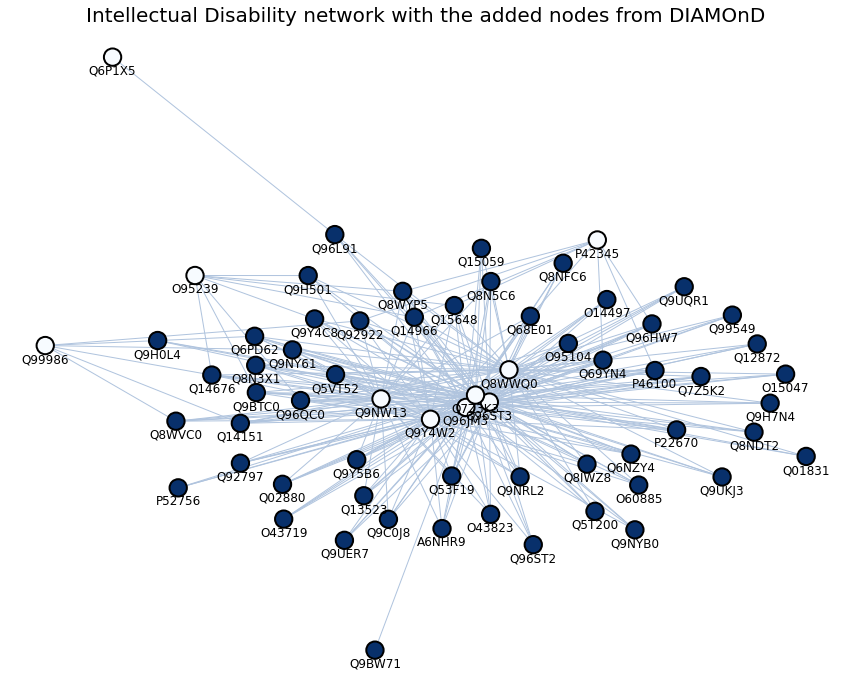

In [12]:
# Visualize this network, the blue nodes are the added nodes, the white nodes are the original disease-related nodes
plt.figure(figsize = (15, 12))

layout = nx.spring_layout(G_added)

node_color = [0 if list(G_added.nodes())[i] in seeds_disease else 1 for i in range(len(list(G_added.nodes())))]
cmap = 'Blues'

nodes = nx.draw_networkx_nodes(G_added, 
                               layout, 
                               node_color = node_color,
                               edgecolors = 'black',  
                               linewidths = 2, 
                               cmap = cmap)
edges = nx.draw_networkx_edges(G_added, 
                               layout, 
                               edge_color = 'lightsteelblue', 
                               width = 1)

# Remove the axis
plt.axis('off')

# Add a title
plt.title('Intellectual Disability network with the added nodes from DIAMOnD', 
          fontsize = 20, 
          color = 'black')

# Add labels to the nodes
labels = {}    
for node in G_added.nodes():
    labels[node] = node

for p in layout:
    layout[p][1] -= 0.04
        
nx.draw_networkx_labels(G_added, 
                        layout, 
                        labels, 
                        font_size = 12)

# Draw the graph
plt.show()

### Create a network with more than 2 direct associations with the already identified disease-related proteins

In [13]:
# Combine the nodes and edges from the seed nodes with the added top 10 nodes
added_nodes = algorithm_df.UniprotAccession[:55].tolist()

# Identify the nodes
nodes_disease = list(set(seeds_disease + added_nodes))

# Identify the edges
edges_disease_df = ass2[ass2['UniprotAccession_A'].isin(nodes_disease) & ass2['UniprotAccession_B'].isin(nodes_disease)]
edges_disease_df = edges_disease_df[edges_disease_df['UniprotAccession_A'] != edges_disease_df['UniprotAccession_B']]
edges_disease_df = edges_disease_df.reset_index(drop=True)

# Retain the nodes that are interconnected in the network
edges_disease_df_2 = edges_disease_df[(edges_disease_df['UniprotAccession_A'].isin(list(added_nodes)) & \
                                       edges_disease_df['UniprotAccession_B'].isin(list(nodes_disease))) | \
                                      (edges_disease_df['UniprotAccession_A'].isin(list(nodes_disease)) & \
                                       edges_disease_df['UniprotAccession_B'].isin(list(added_nodes)))].reset_index(drop=True)

# Identify the direct associations with the already disease-related nodes with interactions
edges_disease_df_3 = edges_disease_df_2[edges_disease_df_2['UniprotAccession_A'].isin(list(set(G_added.nodes())\
                                                                                           .intersection(seeds_disease))) | \
                                        edges_disease_df_2['UniprotAccession_B'].isin(list(set(G_added.nodes())\
                                                                                           .intersection(seeds_disease)))]\
                                        .reset_index(drop=True)

df = pd.DataFrame(data = [sorted([a,b]) for a,b in zip(edges_disease_df_2.UniprotAccession_A, \
                                                       edges_disease_df_2.UniprotAccession_B)], \
                  columns = ['UniprotAccession_A', 'UniprotAccession_B'])
for i in range(df.shape[0]):
    if df.UniprotAccession_A[i] in added_nodes and df.UniprotAccession_B[i] in added_nodes:
        df = df.drop(i)
df.reset_index(drop = True, inplace = True)

occurences = df.UniprotAccession_A.tolist() + df.UniprotAccession_B.tolist()
occurences_count = dict((x, occurences.count(x)) for x in set(occurences))
filtered_occurences = dict((k, occurences_count[k]) for k in added_nodes if k in occurences_count)
filtered_occurences = dict((k, v) for k, v in filtered_occurences.items() if v > 2)
added_nodes = [k  for  k in  filtered_occurences]
edges_disease_df_4 = edges_disease_df_3[(edges_disease_df_3['UniprotAccession_A'].isin(list(added_nodes)) & \
                                       edges_disease_df_3['UniprotAccession_B'].isin(list(nodes_disease))) | \
                                      (edges_disease_df_3['UniprotAccession_A'].isin(list(nodes_disease)) & \
                                       edges_disease_df_3['UniprotAccession_B'].isin(list(added_nodes)))].reset_index(drop=True)

# The edges 
edges_disease = []
for i in range(len(edges_disease_df_4)):
    edges_disease.append(tuple([edges_disease_df_4.UniprotAccession_A[i], edges_disease_df_4.UniprotAccession_B[i]]))

# The nodes
nodes_disease = list(edges_disease_df_4.UniprotAccession_A) + list(edges_disease_df_4.UniprotAccession_B)
    
# Create a network out of this for visualization
G_added = nx.Graph()

# Add the nodes
G_added.add_nodes_from(nodes_disease)

#Add the edges
G_added.add_edges_from(edges_disease)

print(f'The amount of nodes in the added-nodes-protein-association network: {G_added.number_of_nodes()}')
print(f'The amount of edges in the added-nodes-protein-association network: {G_added.number_of_edges()}')

The amount of nodes in the added-nodes-protein-association network: 64
The amount of edges in the added-nodes-protein-association network: 288


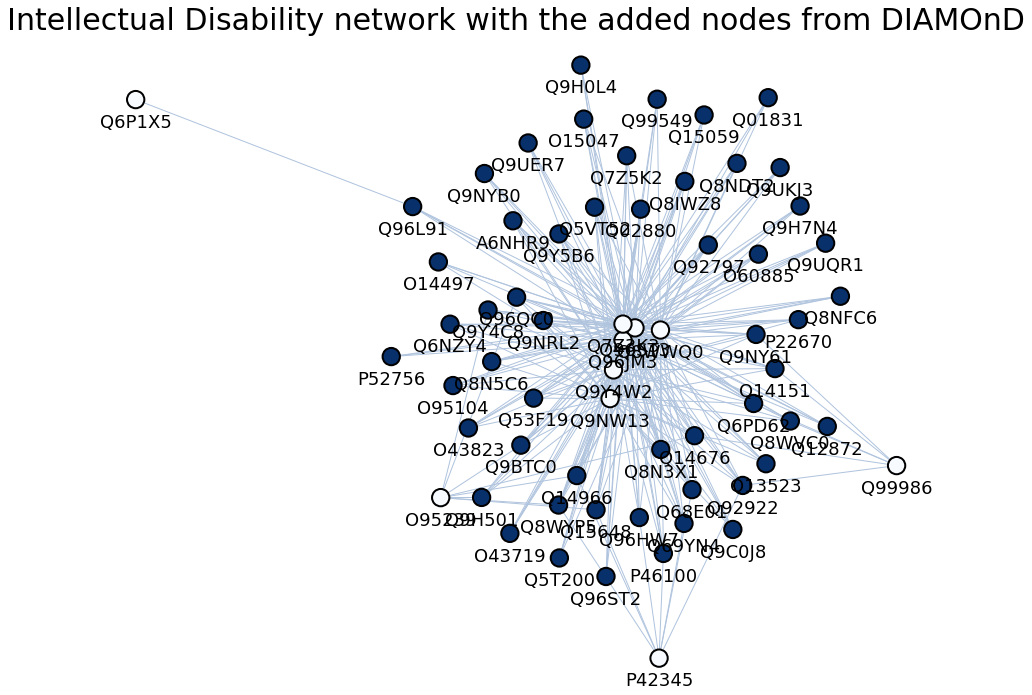

In [14]:
# Visualize this network, the blue nodes are the added nodes, the white nodes are the original disease-related nodes
plt.figure(figsize = (15, 12))

layout = nx.spring_layout(G_added)

node_color = [0 if list(G_added.nodes())[i] in seeds_disease else 1 for i in range(len(list(G_added.nodes())))]
cmap = 'Blues'

nodes = nx.draw_networkx_nodes(G_added, 
                               layout, 
                               node_color = node_color,
                               edgecolors = 'black',  
                               linewidths = 2, 
                               cmap = cmap)
edges = nx.draw_networkx_edges(G_added, 
                               layout, 
                               edge_color = 'lightsteelblue', 
                               width = 1)

# Remove the axis
plt.axis('off')

# Add a title
plt.title('Intellectual Disability network with the added nodes from DIAMOnD', 
          fontsize = 30, 
          color = 'black')

# Add labels to the nodes
labels = {}    
for node in G_added.nodes():
    labels[node] = node

for p in layout:
    layout[p][1] -= 0.04
        
nx.draw_networkx_labels(G_added, 
                        layout, 
                        labels, 
                        font_size = 18)

# Draw the graph
plt.show()

In [15]:
# Get these high interest proteins
proteins_high_interest = set(added_nodes).intersection(nodes_disease)
print(f'The {len(proteins_high_interest)} added proteins with more than 2 connections to already disease-related proteins are:')
for ele in proteins_high_interest:
    print(ele)

The 54 added proteins with more than 2 connections to already disease-related proteins are:
Q9NYB0
P22670
Q6PD62
O15047
Q96QC0
Q9NRL2
O43823
Q8NDT2
Q9Y5B6
Q9NY61
Q9Y4C8
P52756
Q02880
Q8N5C6
Q14151
Q15059
Q14966
Q92797
Q96ST2
O60885
Q6NZY4
O14497
Q96L91
Q92922
Q8WVC0
Q96HW7
Q5T200
Q68E01
Q99549
Q8N3X1
Q9BTC0
Q8NFC6
O95104
Q9UER7
Q9C0J8
Q53F19
Q15648
P46100
Q8WYP5
Q9UKJ3
Q69YN4
Q7Z5K2
Q9UQR1
Q01831
A6NHR9
Q9H501
Q8IWZ8
Q5VT52
Q14676
Q13523
Q9H0L4
Q9H7N4
O43719
Q12872


In further anlysis of the proteins, the following annotations are taken into account:
* Check the **DisGeNet score** of the disease-related proteins
* Check **how high the added proteins are scored according to DIAMOnD**, especially the ones that are connected to all the disease-elated proteins
* Check the **pathways**
* Check the **location**
* Check the **GO biological process**
* Check the **GO molecular function**
* Check the **GO cellular component**

# Leaf Pathway analysis of the added nodes

In [16]:
# Get the added nodes from the DIAMOnD algorithm
added_nodes = algorithm_df.UniprotAccession.tolist()

# Get the UniProt IDs from these proteins and their annotations ordered according to their place from the algorithm
uniprot_ids_added_nodes = uniprot_ids[uniprot_ids.UniprotAccession.isin(added_nodes)]\
                                      .set_index('UniprotAccession')\
                                      .reindex(added_nodes)
uniprot_ids_added_nodes.reset_index(inplace = True)
uniprot_ids_added_nodes = uniprot_ids_added_nodes.astype(str)

# Get the UniProt IDs from the disease-related proteins and their annotations
uniprot_disease_ids = uniprot_ass2[uniprot_ass2.DisGeNet_disease_name.str.contains('Intellectual Disability')]\
                                  .reset_index(drop = True)

In [17]:
# Get all the pathways where the disease-related proteins play a role in 
disease_pathways = []
for i in range(uniprot_disease_ids.shape[0]):
    disease_pathways.extend(uniprot_disease_ids.Reactome_ID[i].split('; '))
disease_pathways = list(set(disease_pathways))
if 'nan' in disease_pathways:
    disease_pathways.remove('nan')
print(f'The Amount of disease-related pathways is {len(disease_pathways)}')

The Amount of disease-related pathways is 343


In [18]:
# UniProt IDs
names1 = uniprot_disease_ids.UniprotAccession.unique()
ids = names1.tolist()
f = open('D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\PPA data 22_02_2021\\Intellectual_Disability_uniprot_ids2.txt','w')
f.write('\n'.join(ids))
f.close()

Unidentified proteins in reactome:
* O43379
* Q00577
* Q96JM3
* O43167
* Q8TCJ2
* Q6RI45
* Q9BY12
* Q9NZJ4
* Q7Z3K3
* Q96M94

## Filter based on overrepresented leaf pathways

In [19]:
# Download the leaf pathways for each uniprot ID
reactome_leaf = pd.read_table("https://reactome.org/download/current/UniProt2Reactome.txt", 
                              sep = '\t', 
                              names = ['UniprotAccession',
                                       'Reactome_ID', 
                                       'URL', 
                                       'Reactome_name', 
                                       'Evidence Code', 
                                       'Species'], index_col=False)
reactome_leaf = reactome_leaf.astype(str)

# Select only human related pathways
reactome_leaf = reactome_leaf[reactome_leaf['Species'] == 'Homo sapiens'].reset_index(drop = True)
reactome_leaf = reactome_leaf[['UniprotAccession', 'Reactome_ID', 'Reactome_name']]

In [20]:
# Filter the results, only retaining leaf pathways
reactome_analysis = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\PPA data 22_02_2021\\Reactome_analysis_Intellectual_Disability2.csv', sep = ',')
reactome_analysis_ids = reactome_analysis[:35]['Pathway identifier'].tolist()
disease_pathways_reactome = reactome_analysis['Pathway identifier'].unique()

# Check how many of these proteins contain the top 35 overrepresented reactome IDs (without the non detected proteins)
leaf_pathways_analyzed = reactome_analysis[reactome_analysis['Pathway identifier']\
                                           .isin(reactome_leaf['Reactome_ID'].tolist())].reset_index(drop = True)
leaf_pathways_analyzed_ids = leaf_pathways_analyzed[:35]['Pathway identifier'].tolist()

# Get the leaf pathway names
reactome_leaf2 = reactome_leaf[['Reactome_ID', 'Reactome_name']].drop_duplicates().reset_index(drop = True)
reactome_leaf2 = reactome_leaf2[reactome_leaf2.Reactome_ID.isin(leaf_pathways_analyzed_ids)]
leaf_pathways_analyzed_ids = reactome_leaf2.Reactome_ID.tolist()
leaf_pathways_analyzed_names = reactome_leaf2.Reactome_name.tolist()

# Check how many of the disease-related proteins contain a pathway in the top 35 overrepresented reactome IDs 
# (without the non detected proteins)
uniprot_disease_ids_3 = uniprot_disease_ids.copy()
for i in range(uniprot_disease_ids_3.shape[0]):
    x = set(uniprot_disease_ids_3.Reactome_ID[i].split('; '))
    if len(x.intersection(leaf_pathways_analyzed_ids)) == 0:
        uniprot_disease_ids_3 = uniprot_disease_ids_3.drop(i)
uniprot_disease_ids_3.reset_index(drop = True)
uniprot_disease_ids_3.shape

(24, 20)

In [72]:
x = reactome_analysis[reactome_analysis['Pathway identifier'].isin(reactome_leaf['Reactome_ID'].tolist())].reset_index(drop = True)
amount_redetected = []
amount_pathways = []
for i in range(101):
    x_1 = x[:i]['Pathway identifier'].tolist()
    uniprot_disease_ids_3 = uniprot_disease_ids.copy()
    for e in range(uniprot_disease_ids_3.shape[0]):
        y = set(uniprot_disease_ids_3.Reactome_ID[e].split('; '))
        if len(y.intersection(x_1)) == 0:
            uniprot_disease_ids_3 = uniprot_disease_ids_3.drop(e)
    amount_redetected.append(uniprot_disease_ids_3.shape[0])
    amount_pathways.append(i)
d = {'proteins': amount_redetected, 'pathways':amount_pathways}
dataframe_lp = pd.DataFrame(d)
dataframe_lp.to_csv('D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Figures\\ID_lp_retention.csv', encoding = 'utf-8', compression = 'gzip', index = False, sep = '\t')

In [21]:
# Check the added nodes for their pathways
uniprot_ids_added_nodes_3 = uniprot_ids_added_nodes.copy()
for i in range(uniprot_ids_added_nodes_3.shape[0]):
    if len(set(uniprot_ids_added_nodes_3.Reactome_ID[i].split('; ')).intersection(leaf_pathways_analyzed_ids)) == 0:
        uniprot_ids_added_nodes_3 = uniprot_ids_added_nodes_3.drop(i)
#uniprot_ids_added_nodes_3.reset_index(drop = True, inplace = True)
uniprot_ids_added_nodes_3.reset_index(drop = True, inplace = True)

# Print the Uniprot IDs of the proteins
leaf_pathway_proteins1 = list(set(uniprot_ids_added_nodes_3.UniprotAccession.tolist()))

print(f'The {len(leaf_pathway_proteins1)} proteins that contain relevant disease-related annotations are:')
for ele in leaf_pathway_proteins1:
    print(ele)

The 5 proteins that contain relevant disease-related annotations are:
O15047
Q9UER7
O14497
Q96L91
Q92922


In [22]:
uniprot_ids_added_nodes_3

,UniprotAccession,Protein_name,Gene_names,GO_biological_process,GO_cellular_component,GO_molecular_function,Reactome_ID,Reactome_name,HPA_gene,HPA_gene_description,HPA_Subcellular_location,CORUM_complexes,CORUM_subunit_IDs,DisGeNet_disease_name,DisGeNet_disease_ID,DisGeNet_class,DisGeNet_gene,DisGeNet_score,DisProt_name,DisProt_ID
0,O14497,AT-rich interactive domain-containing protein ...,ARID1A BAF250 BAF250A C1orf4 OSA1 SMARCF1,androgen receptor signaling pathway [GO:003052...,brahma complex [GO:0035060]; nBAF complex [GO:...,DNA binding [GO:0003677]; nuclear receptor bin...,R-HSA-212436; R-HSA-3214858; R-HSA-3247509; R-...,Generic Transcription Pathway; RMTs methylate ...,ARID1A,AT-rich interaction domain 1A,Nucleoplasm,NUMAC complex (nucleosomal methylation activat...,O14497;P51532;P60709;Q12824;Q86X55;Q8TAQ2;Q929...,Adenocarcinoma; Malignant neoplasm of breast; ...,C0001418; C0006142; C0006826; C0009402; C00246...,Neoplastic Process; Neoplastic Process; Neopla...,ARID1A; ARID1A; ARID1A; ARID1A; ARID1A; ARID1A...,0.39; 0.4; 0.4; 0.49; 0.4; 0.73; 0.35; 0.37; 0...,nan,nan
1,Q92922,SWI/SNF complex subunit SMARCC1 (BRG1-associat...,SMARCC1 BAF155,animal organ morphogenesis [GO:0009887]; ATP-d...,cytoplasm [GO:0005737]; nBAF complex [GO:00715...,chromatin binding [GO:0003682]; histone bindin...,R-HSA-212436; R-HSA-3214858; R-HSA-3247509; R-...,Generic Transcription Pathway; RMTs methylate ...,SMARCC1,"SWI/SNF related, matrix associated, actin depe...",Nucleoplasm,NUMAC complex (nucleosomal methylation activat...,O14497;P51532;P60709;Q12824;Q86X55;Q8TAQ2;Q929...,nan,nan,nan,nan,nan,nan,nan
2,Q9UER7,Death domain-associated protein 6 (Daxx) (hDax...,DAXX BING2 DAP6,activation of JUN kinase activity [GO:0007257]...,"chromosome, centromeric region [GO:0000775]; c...",androgen receptor binding [GO:0050681]; DNA-bi...,R-HSA-157579; R-HSA-1640170; R-HSA-1643685; R-...,Telomere Maintenance; Cell Cycle; Disease; Gen...,DAXX,Death domain associated protein,"Nucleoplasm,Nuclear bodies","Ubiquitin E3 ligase (SPOP, DAXX, CUL3)",O43791;Q13618;Q9UER7; P26358;Q9NPF5;Q9UER7; P4...,Neuroendocrine Tumors,C0206754,Neoplastic Process,DAXX,0.38,Death domain-associated protein 6,DP00707
3,Q96L91,E1A-binding protein p400 (EC 3.6.4.-) (CAG rep...,EP400 CAGH32 KIAA1498 KIAA1818 TNRC12,histone H2A acetylation [GO:0043968]; histone ...,NuA4 histone acetyltransferase complex [GO:003...,ATP binding [GO:0005524]; chromatin binding [G...,R-HSA-2262752; R-HSA-2559583; R-HSA-2559584; R...,Cellular responses to stress; Cellular Senesce...,EP400,E1A binding protein p400,Nucleoplasm,NuA4/Tip60-HAT complex,O95619;O96019;Q15014;Q92993;Q96L91;Q9H0E9;Q9H2...,nan,nan,nan,nan,nan,nan,nan
4,O15047,Histone-lysine N-methyltransferase SETD1A (EC ...,SETD1A KIAA0339 KMT2F SET1 SET1A,brain development [GO:0007420]; histone H3-K4 ...,histone methyltransferase complex [GO:0035097]...,beta-catenin binding [GO:0008013]; histone met...,R-HSA-212436; R-HSA-3214841; R-HSA-3247509; R-...,Generic Transcription Pathway; PKMTs methylate...,SETD1A,SET domain containing 1A,Nuclear speckles,MOF complex,O14686;O15047;P21675;P49848;P61964;Q03164;Q152...,Schizophrenia,C0036341,Mental or Behavioral Dysfunction,SETD1A,0.65,nan,nan


In [23]:
# Get all the reactome data
reactome_data = pd.read_table("https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt", 
                              sep = '\t', names = ['UniProtID',
                                                   'Reactome Pathway Stable identifier',
                                                   'URL',
                                                   'Event (Pathway or Reaction) Name',
                                                   'Evidence Code',
                                                   'Species'])
# Select only human related pathways
reactome_data = reactome_data[reactome_data['Species'] == 'Homo sapiens']

# Retain only the necessary columns and change their names
reactome_data = reactome_data[['Reactome Pathway Stable identifier', 
                               'Event (Pathway or Reaction) Name']]
reactome_data.rename(columns = {'Reactome Pathway Stable identifier' : 'Reactome_ID',
                                'Event (Pathway or Reaction) Name' : 'Reactome_name'}, inplace = True)
reactome_data = reactome_data.drop_duplicates().reset_index(drop = True)
reactome_id_all = reactome_data[reactome_data.Reactome_ID.isin(disease_pathways)].reset_index(drop = True)

# Get the IDs with their description
reactome_top_ids = reactome_id_all[reactome_id_all.Reactome_ID.isin(reactome_analysis_ids)].reset_index(drop = True)

## Filter these results based on other shared annotations

Other shared annotations include: subcellular location, GO biological process, GO molecular function and GO cellular component.

In [24]:
# Get the added proteins of the DIAMOnD algorithm
diamond_idenitified = algorithm_df[algorithm_df['UniprotAccession']\
                                   .isin(list(set(G.nodes()).intersection(added_nodes)))]

# Get all the UniProt IDs of both the already disease-related proteins and the added proteins
uniprot_disease_annotations = uniprot_ass2[uniprot_ass2.UniprotAccession\
                                          .isin(list(set(G.nodes()).intersection(seeds_disease)))]\
                                          .reset_index(drop = True)
uniprot_disease_annotations_added = uniprot_ass2[uniprot_ass2.UniprotAccession\
                                          .isin(diamond_idenitified.UniprotAccession.tolist())]\
                                          .reset_index(drop = True)

uniprot_disease_annotations = uniprot_disease_annotations.astype(str)
uniprot_disease_annotations_added = uniprot_disease_annotations_added.astype(str)

### Subcellular Location

In [25]:
# Get the subcellular locations where the disease-related proteins are mainly present
disease_locations = []
for i in range(uniprot_disease_annotations.shape[0]):
    disease_locations.extend(uniprot_disease_annotations.HPA_Subcellular_location[i].split(','))
disease_locations = list(set(disease_locations))
if 'nan' in disease_locations:
    disease_locations.remove('nan') 

### GO biological process

In [26]:
# Get the GO biological processes where the disease-related proteins play a role in 
disease_GObps = []
for i in range(uniprot_disease_annotations.shape[0]):
    disease_GObps.extend(uniprot_disease_annotations.GO_biological_process[i].split('; '))
disease_GObps = list(set(disease_GObps))
if 'nan' in disease_GObps:
    disease_GObps.remove('nan')        

### GO molecular function

In [27]:
# Get the GO biological processes where the disease-related proteins play a role in 
disease_GOmfs = []
for i in range(uniprot_disease_annotations.shape[0]):
    disease_GOmfs.extend(uniprot_disease_annotations.GO_molecular_function[i].split('; '))
disease_GOmfs = list(set(disease_GOmfs))

if 'nan' in disease_GOmfs:
    disease_GOmfs.remove('nan')

### GO cellular component

In [28]:
# Get the GO biological processes where the disease-related proteins play a role in 
disease_GOccs = []
for i in range(uniprot_disease_annotations.shape[0]):
    disease_GOccs.extend(uniprot_disease_annotations.GO_cellular_component[i].split('; '))
disease_GOccs = list(set(disease_GOccs))

if 'nan' in disease_GOccs:
    disease_GOccs.remove('nan')

### Put the common annotations in a dataframe

In [29]:
# Put all the shared annotations in a dataframe and see which proteins would be the best match
ids_3 = uniprot_ids_added_nodes_3.UniprotAccession.tolist()
shared_annotations = pd.DataFrame()
shared_annotations['UniprotAccession'], \
shared_annotations['Leaf_Pathways_IDs'], \
shared_annotations['Leaf_Pathways_Names'], \
shared_annotations['Subcellular_location'], \
shared_annotations['GO_Biological_Process'], \
shared_annotations['GO_Molecular_Function'], \
shared_annotations['GO_Cellular_Component'] = [ele for ele in ids_3], ['' for i in range(len(ids_3))], \
                                              ['' for i in range(len(ids_3))], ['' for i in range(len(ids_3))], \
                                              ['' for i in range(len(ids_3))], ['' for i in range(len(ids_3))], \
                                              ['' for i in range(len(ids_3))]
for ele in ids_3:
    x = pd.DataFrame(uniprot_ids_added_nodes_3[uniprot_ids_added_nodes_3.UniprotAccession == ele]).reset_index(drop = True)
    x_p = list(set(x.Reactome_ID[0].split('; ')).intersection(leaf_pathways_analyzed_ids))
    x_p_name = list(set(x.Reactome_name[0].split('; ')).intersection(leaf_pathways_analyzed_names))
    x_l = list(set(x.HPA_Subcellular_location[0].split(',')).intersection(disease_locations))
    x_go_bp = list(set(x.GO_biological_process[0].split('; ')).intersection(disease_GObps))
    x_go_mf = list(set(x.GO_molecular_function[0].split('; ')).intersection(disease_GOmfs))
    x_go_cc = list(set(x.GO_cellular_component[0].split('; ')).intersection(disease_GOccs))
    
    if len(x_p) == 0:
        shared_annotations.Leaf_Pathways_IDs[ids_3.index(ele)] = np.nan
    else:
        shared_annotations.Leaf_Pathways_IDs[ids_3.index(ele)] = '; '.join(x_p)
    
    if len(x_p_name) == 0:
        shared_annotations.Leaf_Pathways_Names[ids_3.index(ele)] = np.nan
    else:
        shared_annotations.Leaf_Pathways_Names[ids_3.index(ele)] = '; '.join(x_p_name)
    
    if len(x_l) == 0:
        shared_annotations.Subcellular_location[ids_3.index(ele)] = np.nan
    else:
        shared_annotations.Subcellular_location[ids_3.index(ele)] = '; '.join(x_l)
    
    if len(x_go_bp) == 0:
        shared_annotations.GO_Biological_Process[ids_3.index(ele)] = np.nan
    else:
        shared_annotations.GO_Biological_Process[ids_3.index(ele)] = '; '.join(x_go_bp)
    
    if len(x_go_mf) == 0:
        shared_annotations.GO_Molecular_Function[ids_3.index(ele)] = np.nan
    else:
        shared_annotations.GO_Molecular_Function[ids_3.index(ele)] = '; '.join(x_go_mf)
    
    if len(x_go_cc) == 0:
        shared_annotations.GO_Cellular_Component[ids_3.index(ele)] = np.nan
    else:
        shared_annotations.GO_Cellular_Component[ids_3.index(ele)] = '; '.join(x_go_cc)

shared_annotations

,UniprotAccession,Leaf_Pathways_IDs,Leaf_Pathways_Names,Subcellular_location,GO_Biological_Process,GO_Molecular_Function,GO_Cellular_Component
0,O14497,R-HSA-3247509,Chromatin modifying enzymes,Nucleoplasm,"positive regulation of transcription, DNA-temp...",DNA binding [GO:0003677]; transcription coacti...,nuclear chromatin [GO:0000790]; nucleus [GO:00...
1,Q92922,R-HSA-3247509,Chromatin modifying enzymes,Nucleoplasm,insulin receptor signaling pathway [GO:0008286...,histone binding [GO:0042393]; transcription co...,nuclear chromatin [GO:0000790]; nucleus [GO:00...
2,Q9UER7,R-HSA-3899300,SUMOylation of transcription cofactors,Nuclear bodies; Nucleoplasm,positive regulation of protein phosphorylation...,transcription corepressor activity [GO:0003714...,PML body [GO:0016605]; nucleolus [GO:0005730];...
3,Q96L91,R-HSA-3247509,Chromatin modifying enzymes,Nucleoplasm,NaN,DNA binding [GO:0003677]; ATP binding [GO:0005...,nucleoplasm [GO:0005654]; nuclear speck [GO:00...
4,O15047,R-HSA-3247509; R-HSA-3214841,PKMTs methylate histone lysines; Chromatin mod...,Nuclear speckles,brain development [GO:0007420]; regulation of ...,transcription factor binding [GO:0008134]; his...,nuclear speck [GO:0016607]; nuclear chromatin ...


In [30]:
shared_annotations_proteins = list(set(shared_annotations.UniprotAccession.tolist()))

print(f'The {len(shared_annotations_proteins)} proteins that contain relevant disease-related annotations are:')
for ele in shared_annotations_proteins:
    print(ele)

The 5 proteins that contain relevant disease-related annotations are:
O15047
Q9UER7
O14497
Q96L91
Q92922


# The eventual proteins that share highly prominent disease-related pathways and that contain other disease-related annotations as well

In [31]:
leaf_pathway_filtered_proteins = list(set(shared_annotations.UniprotAccession.tolist()))
common_with_high_interest = proteins_high_interest.intersection(leaf_pathway_filtered_proteins)

print(f'The {len(leaf_pathway_filtered_proteins)} proteins that contain overrepresented leaf pathways\nand other shared annotations are:')
for ele in leaf_pathway_filtered_proteins:
    print(ele)
    
print(f'\nThe {len(common_with_high_interest)} added proteins that contain relevant disease-related annotations\nand that were already identified as high interest proteins:')
for ele in common_with_high_interest:
    print(ele)

The 5 proteins that contain overrepresented leaf pathways
and other shared annotations are:
O15047
Q9UER7
O14497
Q96L91
Q92922

The 5 added proteins that contain relevant disease-related annotations
and that were already identified as high interest proteins:
O15047
Q9UER7
O14497
Q96L91
Q92922


In [32]:
# Check How highly the proteins are ranked according to the DIAMOnD algorithm
diamond_idenitified = algorithm_df[algorithm_df['UniprotAccession'].isin(leaf_pathway_filtered_proteins)].reset_index()
diamond_idenitified.rename(columns = {'index' : 'DIAMOnD_ranking'}, inplace = True)
diamond_idenitified

,DIAMOnD_ranking,UniprotAccession,Degree,Amount_of_neigbors,P-value
0,0,O14497,40,4,[0.0032157745850399755]
1,5,Q92922,241,12,[0.0005806381506327021]
2,20,Q9UER7,160,20,[3.616544236404726e-11]
3,49,Q96L91,152,42,[2.3140518073539435e-32]
4,51,O15047,126,41,[2.1004369449429275e-34]


In [33]:
# Merge the order of DIAMOnD ranking with all the shared annotations
diamond_idenitified2 = diamond_idenitified[['DIAMOnD_ranking', 'UniprotAccession']]
shared_annotations_final = pd.merge(diamond_idenitified2, shared_annotations, how = 'left', on = 'UniprotAccession')
shared_annotations_final

,DIAMOnD_ranking,UniprotAccession,Leaf_Pathways_IDs,Leaf_Pathways_Names,Subcellular_location,GO_Biological_Process,GO_Molecular_Function,GO_Cellular_Component
0,0,O14497,R-HSA-3247509,Chromatin modifying enzymes,Nucleoplasm,"positive regulation of transcription, DNA-temp...",DNA binding [GO:0003677]; transcription coacti...,nuclear chromatin [GO:0000790]; nucleus [GO:00...
1,5,Q92922,R-HSA-3247509,Chromatin modifying enzymes,Nucleoplasm,insulin receptor signaling pathway [GO:0008286...,histone binding [GO:0042393]; transcription co...,nuclear chromatin [GO:0000790]; nucleus [GO:00...
2,20,Q9UER7,R-HSA-3899300,SUMOylation of transcription cofactors,Nuclear bodies; Nucleoplasm,positive regulation of protein phosphorylation...,transcription corepressor activity [GO:0003714...,PML body [GO:0016605]; nucleolus [GO:0005730];...
3,49,Q96L91,R-HSA-3247509,Chromatin modifying enzymes,Nucleoplasm,NaN,DNA binding [GO:0003677]; ATP binding [GO:0005...,nucleoplasm [GO:0005654]; nuclear speck [GO:00...
4,51,O15047,R-HSA-3247509; R-HSA-3214841,PKMTs methylate histone lysines; Chromatin mod...,Nuclear speckles,brain development [GO:0007420]; regulation of ...,transcription factor binding [GO:0008134]; his...,nuclear speck [GO:0016607]; nuclear chromatin ...


In [34]:
# Save the dataframe
shared_annotations_final.to_excel('D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Results\\Intellectual_disability_shared_annotations.xlsx', index = False)

In [67]:
# Put all the Reactomne IDs and their corresponding definitions into a dataframe
shared_annotations_final = shared_annotations_final.astype(str)
ids_path = set()
path = shared_annotations_final.Leaf_Pathways_IDs.tolist()
for i in range(len(path)):
    path_split = path[i].split('; ')
    for e in range(len(path_split)):
        ids_path.add(path_split[e])
dataframe = reactome_data[reactome_data.Reactome_ID.isin(list(ids_path))]
dataframe.to_excel('D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Figures\\Intellectual_disability_pathway_names.xlsx', index = False)

In [68]:
# Put all GO annotations and their corresponding definitions into a dataframe 
ids_go_bp = set()
go_bp = shared_annotations_final.GO_Biological_Process.tolist()
for i in range(len(go_bp)):
    go_bp_split = go_bp[i].split('; ')
    for e in range(len(go_bp_split)):
        ids_go_bp.add(go_bp_split[e])

ids_go_bp = list(ids_go_bp)
if 'nan' in ids_go_bp:
    ids_go_bp.remove('nan')
name_bp = []
ids_bp = []
for i in range(len(ids_go_bp)):
    a, b = ids_go_bp[i].split(' [')
    name_bp.append(a)
    c, d = b.split(']')
    ids_bp.append(c)

d_bp = {'Identifier':ids_bp,'Definition':name_bp}
dataframe_go_bp = pd.DataFrame(d_bp)

ids_go_mf = set()
go_mf = shared_annotations_final.GO_Molecular_Function.tolist()
for i in range(len(go_mf)):
    go_mf_split = go_mf[i].split('; ')
    for e in range(len(go_mf_split)):
        ids_go_mf.add(go_mf_split[e])

ids_go_mf = list(ids_go_mf)
if 'nan' in ids_go_mf:
    ids_go_mf.remove('nan')
name_mf = []
ids_mf = []
for i in range(len(ids_go_mf)):
    a, b = ids_go_mf[i].split(' [')
    name_mf.append(a)
    c, d = b.split(']')
    ids_mf.append(c)

d_mf = {'Identifier':ids_mf,'Definition':name_mf}
dataframe_go_mf = pd.DataFrame(d_mf)

ids_go_cc = set()
go_cc = shared_annotations_final.GO_Cellular_Component.tolist()
for i in range(len(go_cc)):
    go_cc_split = go_cc[i].split('; ')
    for e in range(len(go_cc_split)):
        ids_go_cc.add(go_cc_split[e])

ids_go_cc = list(ids_go_cc)
if 'nan' in ids_go_cc:
    ids_go_cc.remove('nan')
name_cc = []
ids_cc = []
for i in range(len(ids_go_cc)):
    a, b = ids_go_cc[i].split(' [')
    name_cc.append(a)
    c, d = b.split(']')
    ids_cc.append(c)

d_cc = {'Identifier':ids_cc,'Definition':name_cc}
dataframe_go_cc = pd.DataFrame(d_cc)

dataframe_go = dataframe_go_bp.append([dataframe_go_mf, dataframe_go_cc]).reset_index(drop = True)
dataframe_go.drop_duplicates(inplace = True)
dataframe_go.to_excel('D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Figures\\Intellectual_disability_go_names.xlsx', index = False)

# Check the found proteins manually to verify their associations

The 3 proteins that contain overrepresented leaf pathways and other shared annotations are:
* Q9UER7
* O14497
* Q92922

The 3 added proteins that contain relevant disease-related annotations and that were already identified as high interest proteins:
* Q9UER7
* O14497
* Q92922

In [35]:
# Get all the DisGeNet associated disease-related proteins
disgenet_or_data = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\DisGeNet_all_gene_disease_associations.tsv.gz', compression = 'gzip', sep='\t')
disgenet_uniprot = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\DisGeNet_uniprot_mapping.tsv.gz', compression = 'gzip', sep='\t')

# Merge the UniProt IDs on the DisGeNet data
disgenet_data = pd.merge(disgenet_or_data, disgenet_uniprot, left_on='geneId', right_on='GENEID')

# Retain only the necessary columns and change their names
disgenet_data = disgenet_data[['UniProtKB',  
                               'diseaseName', 
                               'score']]

disgenet_data.rename(columns = {'UniProtKB' : 'UniprotAccession',
                                'diseaseName' : 'DisGeNet_disease_name',
                                'score' : 'DisGeNet_score'}, inplace = True)

# Filter all Breast Carcinoma proteins
disease_all = disgenet_data[disgenet_data.DisGeNet_disease_name == 'Intellectual Disability'].reset_index(drop = True)
disease_all.sort_values(by = 'DisGeNet_score', ascending = False, inplace = True)
disease_all.reset_index(drop = True, inplace = True)

# See if there are any proteins that already contain a DisGeNet score
added_with_score_df = disease_all[disease_all.UniprotAccession.isin(diamond_idenitified.UniprotAccession.tolist())].reset_index(drop = True)
added_with_score = added_with_score_df.UniprotAccession.tolist()
added_without_score = list(set(diamond_idenitified.UniprotAccession.tolist()) - set(added_with_score))

print(f'The {len(added_with_score)} proteins that contain a low DisGeNet score:')
for i in range(added_with_score_df.shape[0]):
    x = added_with_score_df.DisGeNet_score[i]
    print(f'{added_with_score_df.UniprotAccession[i]}, DisGeNet score: {x}')

print(f'\nThe {len(added_without_score)} proteins that do not contain a DisGeNet score:')
for ele in added_without_score:
    print(ele)

The 2 proteins that contain a low DisGeNet score:
O15047, DisGeNet score: 0.3
O14497, DisGeNet score: 0.13

The 3 proteins that do not contain a DisGeNet score:
Q96L91
Q92922
Q9UER7


In [36]:
# Get all the DisGeNet associated disease-related proteins
disgenet_or_data = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\DisGeNet_all_gene_disease_associations.tsv.gz', compression = 'gzip', sep='\t')
disgenet_uniprot = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\DisGeNet_uniprot_mapping.tsv.gz', compression = 'gzip', sep='\t')

# Merge the UniProt IDs on the DisGeNet data
disgenet_data = pd.merge(disgenet_or_data, disgenet_uniprot, left_on='geneId', right_on='GENEID')

# Retain only the necessary columns and change their names
disgenet_data = disgenet_data[['UniProtKB',  
                               'diseaseName', 
                               'score']]

disgenet_data.rename(columns = {'UniProtKB' : 'UniprotAccession',
                                'diseaseName' : 'DisGeNet_disease_name',
                                'score' : 'DisGeNet_score'}, inplace = True)

# Filter all Breast Carcinoma proteins
disease_all = disgenet_data[disgenet_data.DisGeNet_disease_name == 'Intellectual Disability'].reset_index(drop = True)
disease_all.sort_values(by = 'DisGeNet_score', ascending = False, inplace = True)
disease_all.reset_index(drop = True, inplace = True)

# See if there are any proteins that already contain a DisGeNet score
added_with_score_df = disease_all[disease_all.UniprotAccession.isin(diamond_idenitified2.UniprotAccession.tolist())].reset_index(drop = True)
added_with_score = added_with_score_df.UniprotAccession.tolist()
added_without_score = list(set(diamond_idenitified2.UniprotAccession.tolist()) - set(added_with_score))

print(f'The {len(added_with_score)} proteins that contain a low DisGeNet score:')
for i in range(added_with_score_df.shape[0]):
    x = added_with_score_df.DisGeNet_score[i]
    print(f'{added_with_score_df.UniprotAccession[i]}, DisGeNet score: {x}')

print(f'\nThe {len(added_without_score)} proteins that do not contain a DisGeNet score:')
for ele in added_without_score:
    print(ele)

The 2 proteins that contain a low DisGeNet score:
O15047, DisGeNet score: 0.3
O14497, DisGeNet score: 0.13

The 3 proteins that do not contain a DisGeNet score:
Q96L91
Q92922
Q9UER7


# Get the amount of disease-related proteins each protein is connected to:

In [37]:
for i in range(len(leaf_pathway_proteins1)):
    edges_p = ass2[ass2['UniprotAccession_A'].isin([leaf_pathway_proteins1[i]]) | \
                   ass2['UniprotAccession_B'].isin([leaf_pathway_proteins1[i]])]
    edges_p = edges_p[edges_p['UniprotAccession_A'].isin(seeds_disease) | \
                      edges_p['UniprotAccession_B'].isin(seeds_disease)]
    print(f'\nProtein: {leaf_pathway_proteins1[i]}, amount of disease-associated neighbors: {edges_p.shape[0]}')


Protein: O15047, amount of disease-associated neighbors: 4

Protein: Q9UER7, amount of disease-associated neighbors: 4

Protein: O14497, amount of disease-associated neighbors: 4

Protein: Q96L91, amount of disease-associated neighbors: 5

Protein: Q92922, amount of disease-associated neighbors: 8


# Create a graph visualizing the proteins

In [38]:
proteins_graph_added = shared_annotations_final.UniprotAccession.tolist()
graph = ass2[(ass2.UniprotAccession_A.isin(proteins_graph_added) & ass2.UniprotAccession_B.isin(seeds_disease)) |\
             (ass2.UniprotAccession_B.isin(proteins_graph_added) & ass2.UniprotAccession_A.isin(seeds_disease))].reset_index(drop = True)

# The edges 
edges = []
for i in range(len(graph)):
    edges.append(tuple([graph.UniprotAccession_A[i], graph.UniprotAccession_B[i]]))

# The nodes
nodes = list(graph.UniprotAccession_A) + list(graph.UniprotAccession_B)
    
# Create a network out of this for visualization
G_graph = nx.Graph()

# Add the nodes
G_graph.add_nodes_from(nodes)

#Add the edges
G_graph.add_edges_from(edges)

print(f'The amount of nodes in the added-nodes-protein-association network1: {G_graph.number_of_nodes()}')
print(f'The amount of edges in the added-nodes-protein-association network1: {G_graph.number_of_edges()}')

The amount of nodes in the added-nodes-protein-association network1: 14
The amount of edges in the added-nodes-protein-association network1: 25


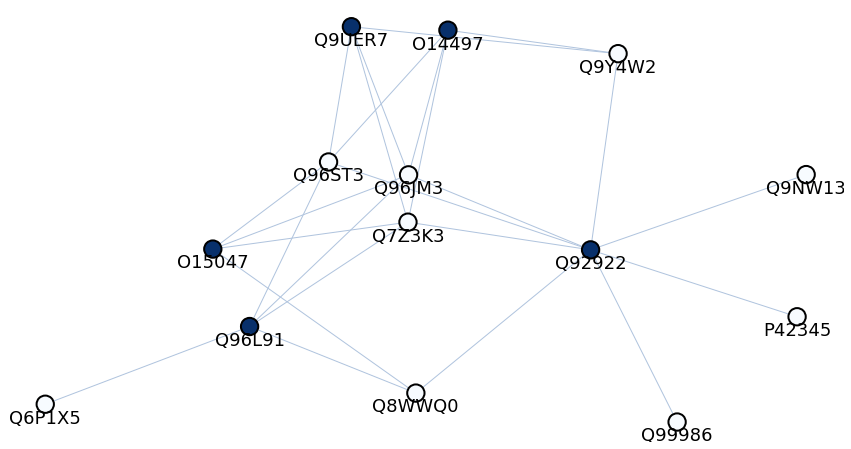

In [39]:
# Visualize this network, the blue nodes are the added nodes, the white nodes are the original disease-related nodes
plt.figure(figsize = (15, 8))

layout = nx.kamada_kawai_layout(G_graph)

node_color = [0 if list(G_graph.nodes())[i] in seeds_disease else 1 for i in range(len(list(G_graph.nodes())))]
cmap = 'Blues'

nodes = nx.draw_networkx_nodes(G_graph, 
                               layout, 
                               node_color = node_color,
                               edgecolors = 'black',  
                               linewidths = 2, 
                               cmap = cmap)
edges = nx.draw_networkx_edges(G_graph, 
                               layout, 
                               edge_color = 'lightsteelblue', 
                               width = 1)

# Remove the axis
plt.axis('off')

# Add labels to the nodes
labels = {}    
for node in G_graph.nodes():
    labels[node] = node

for p in layout:
    layout[p][1] -= 0.045
        
nx.draw_networkx_labels(G_graph, 
                        layout, 
                        labels, 
                        font_size = 18)

# Draw the graph
plt.savefig('D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Figures\\Intellectual_disability_plot_thesis1.png', bbox_inches='tight',pad_inches = 0)
plt.show()